## Notes
Each trial has different items, each with own value (different items for each trial)

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline


In [3]:
# directories
data_dir = '../data/'
setsizes = np.array([9, 16, 25, 36])
numsubjects = 49

In [4]:
subject = 2
c = 36
tmp_data = pd.read_csv(data_dir+'subject_files/sub-{}_setsize-{}_desc-gazes.csv'.format(subject, c))
tmp_data.head()

,subject,setsize,trial,item,dur,onset,stimulus,gaze_num,is_returning,returning_gaze_count,is_last,is_first,item_value,choice,is_last_to_choice
0,2,36,1,15,144.0,424.0,nr4.png,1.0,0.0,0.0,0.0,1.0,1.0,6,0.0
1,2,36,1,14,136.0,604.0,nr51.png,2.0,0.0,0.0,0.0,0.0,-2.0,6,0.0
2,2,36,1,8,206.0,782.0,nr44.png,3.0,0.0,0.0,0.0,0.0,2.0,6,0.0
3,2,36,1,16,210.0,1210.0,nr56.png,4.0,0.0,0.0,0.0,0.0,0.0,6,0.0
4,2,36,1,33,246.0,1616.0,nr90.png,5.0,0.0,0.0,0.0,0.0,2.0,6,0.0


In [5]:
items_df = tmp_data[['trial', 'item', 'item_value', 'stimulus']]
#items_df = items_df.drop_duplicates()
items_df.query('item==21')

,trial,item,item_value,stimulus
75,29,21,-2.0,nr120.png
155,42,21,-2.0,nr94.png
170,46,21,1.0,nr10.png
179,46,21,1.0,nr10.png
180,47,21,3.0,nr89.png
192,49,21,1.0,nr101.png
215,55,21,2.0,nr60.png
222,56,21,-2.0,nr46.png
228,56,21,-2.0,nr46.png
231,58,21,1.0,nr74.png


In [9]:
tmp_data.head()

,subject,setsize,trial,item,dur,onset,stimulus,gaze_num,is_returning,returning_gaze_count,is_last,is_first,item_value,choice,is_last_to_choice
0,2,36,1,15,144.0,424.0,nr4.png,1.0,0.0,0.0,0.0,1.0,1.0,6,0.0
1,2,36,1,14,136.0,604.0,nr51.png,2.0,0.0,0.0,0.0,0.0,-2.0,6,0.0
2,2,36,1,8,206.0,782.0,nr44.png,3.0,0.0,0.0,0.0,0.0,2.0,6,0.0
3,2,36,1,16,210.0,1210.0,nr56.png,4.0,0.0,0.0,0.0,0.0,0.0,6,0.0
4,2,36,1,33,246.0,1616.0,nr90.png,5.0,0.0,0.0,0.0,0.0,2.0,6,0.0


<AxesSubplot: >

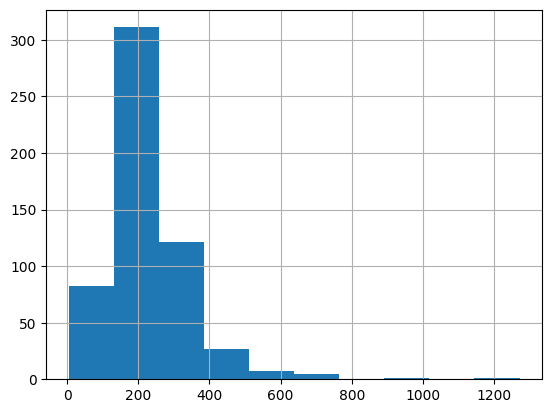

In [6]:
# check duration distro of duration - many short ones
tmp_data.dur.hist()

In [19]:
c = 36
session_nums = []
choices = []
item_value_dict = {}
for subject in range(numsubjects):
    tmp_data = pd.read_csv(data_dir+'subject_files/sub-{}_setsize-{}_desc-gazes.csv'.format(subject, c))
    session_nums.append( len(tmp_data.trial.unique()))
    choices.append(len(tmp_data.choice.unique()))
    items = tmp_data[['item', 'item_value']]

In [20]:
df = pd.DataFrame({"sessions":session_nums, "choices":choices})

In [21]:
df.choices.describe()

count    49.000000
mean     24.551020
std       3.697191
min      13.000000
25%      23.000000
50%      25.000000
75%      27.000000
max      31.000000
Name: choices, dtype: float64

<AxesSubplot:ylabel='Frequency'>

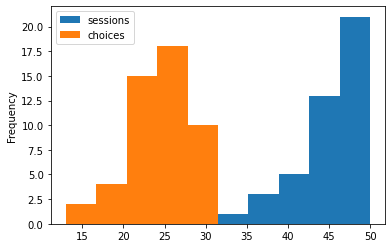

In [22]:
df.plot.hist()

## For each subject, size, trial config, extract the matrix of item value
To be used by ikaros model